# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

Resouces:
* Ground truth notebook - https://github.com/VanLinLin/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [55]:
what_were_covering = {1: "data (prepare and load)",
                                2: "build model",
                                3: "fitting the model to data (training)",
                                4: "making prediction and evaluting a model (inference)",
                                5: "saving and loading a model",
                                6: "putting a it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making prediction and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting a it all together'}

In [56]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.0+cu117'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Video (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

TO showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to nake a straight line with known **parameters**.

In [57]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[: 10], y[: 10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [58]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and set with our data.

In [59]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[: train_split], y[: train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [60]:
def plot_prediction(train_data=X_train, 
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

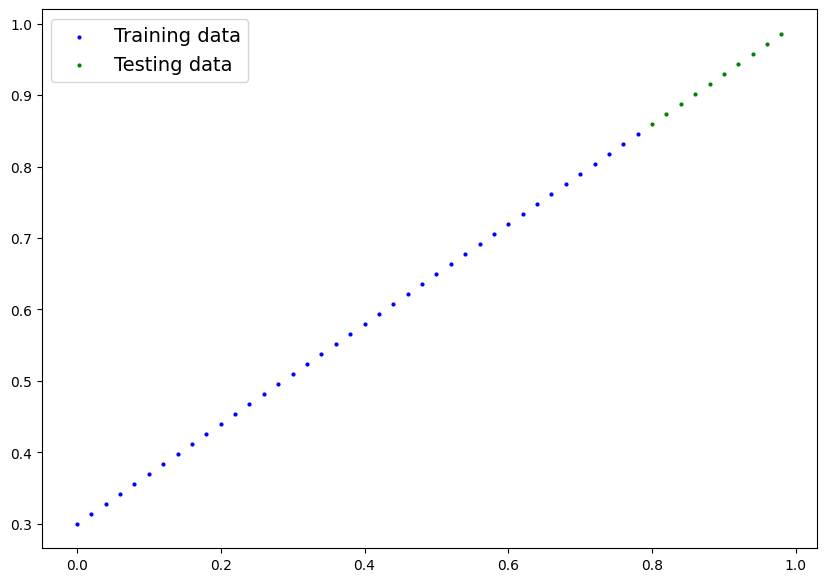

In [61]:
plot_prediction()


## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python:https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?
1. Gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [62]:
from torch import nn


# Create linear regression model class
class LinearRegressionModel(nn.Module):  # <- alomst everything in PyTorch inherhits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,  # <- start with random weights (this will get adjusted as the model learns)
                                                        dtype=torch.float),  # <- PyTorch loves float32 by default
                                                        requires_grad=True)  # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1,  # <- start with random bias (this will get adjusted as the model learns)
                                                    dtype=torch.float),  # <- PyTorch loves float32 by default
                                                    requires_grad=True)  # <- can we update this value with gradient descent?))

        # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
            return self.weights * x + self.bias  # this is the linear regression formula


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subcalss it, you should overwrite forward()
* torch.optim - this whrer the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

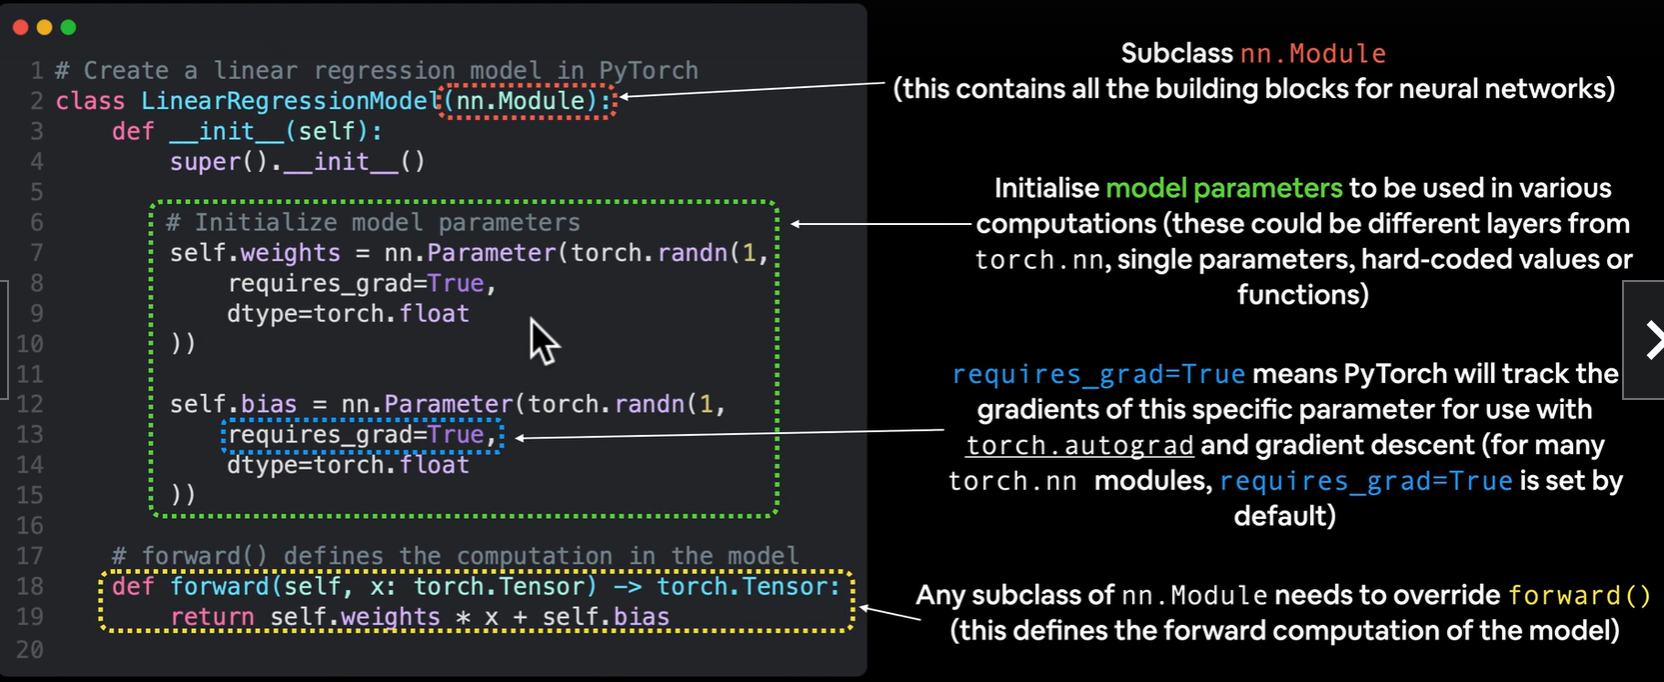

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.Parameters()`.

In [63]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [64]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predic `y_test` based on `X_test`.

When we pass data through our model, it's goiung to run it through the `forward()` method.

In [65]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred.
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here - https://twitter.com/PyTorch/status/1437838231505096708

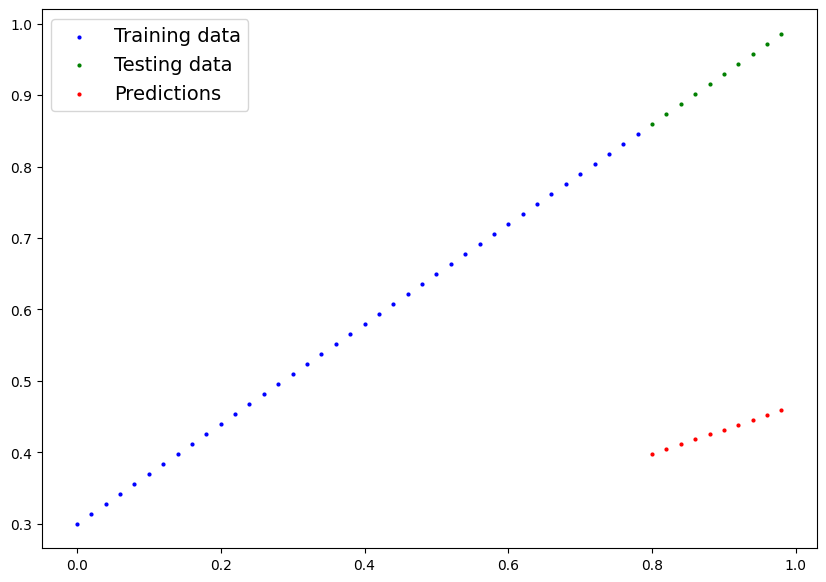

In [66]:
plot_prediction(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wring your models predictions are is to use a loss function.

Things we need to train:

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going ot refer to i as a loss function.
* **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias in our case) to improve the loss function - https://pytorch.org/docs/stable/optim.html#module-torch.optim
  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr`(learning rate) - the learning rate is a hyperparemeter that defines how big/small the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* An training loop
* A testing loop

In [67]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [68]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [69]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                                lr=0.01)  # lr = learning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?

**A:** This will be problem sepcific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely want to user a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions- also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [70]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 100

# 0. Loop throuth the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_preds = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_preds, y_train)
    print(F"Loss: {loss}")

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()  # by default how the optimizer changes will acculumate through the loop so... we have to zero them above in step 3 for the next iteration of the loop

    ### Testing 
    model_0.eval()  # truns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
    with torch.inference_mode():  # turns off gradient tracking & a couple more things behind the scenes
    # with torch.no_grad():  # you may also see torch.no_grad() in order PyTorch code
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(F"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    # Print out model state_dict()
    print(model_0.state_dict())

Loss: 0.31288138031959534
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Loss: 0.2783183455467224
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
Loss: 0.23223432898521423
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
Loss: 0.22071333229541779
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
Loss: 0.20919232070446014
OrderedDict([('w

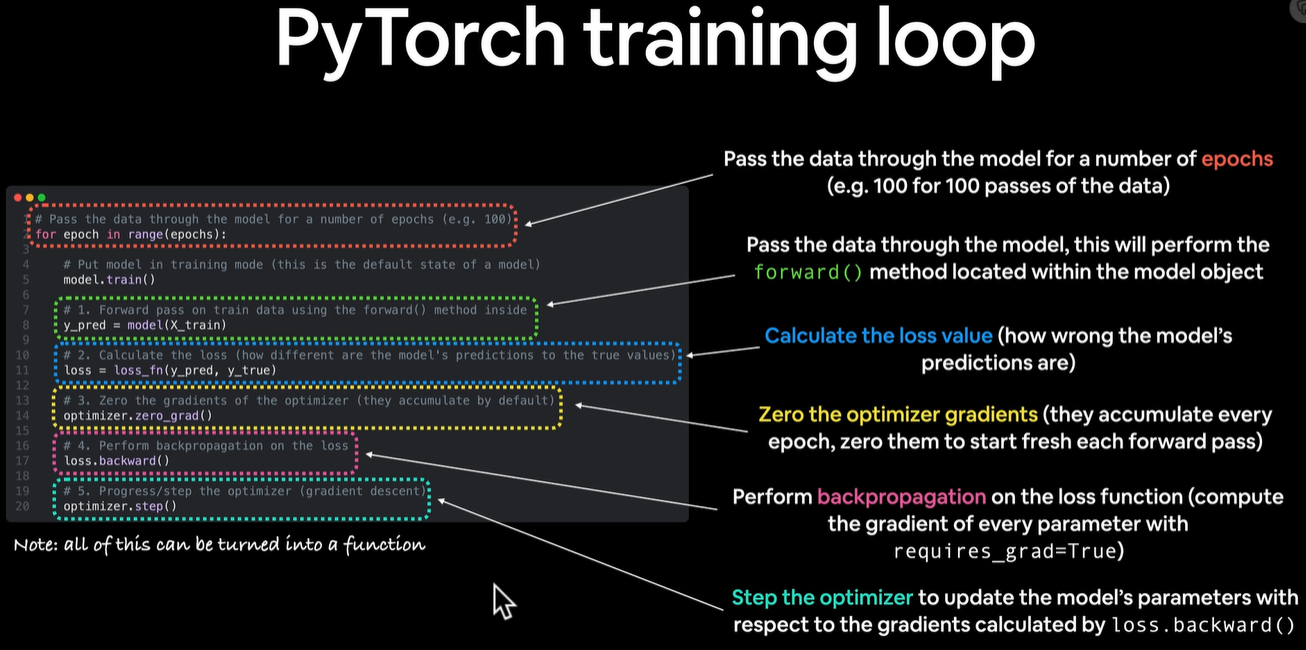

In [71]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

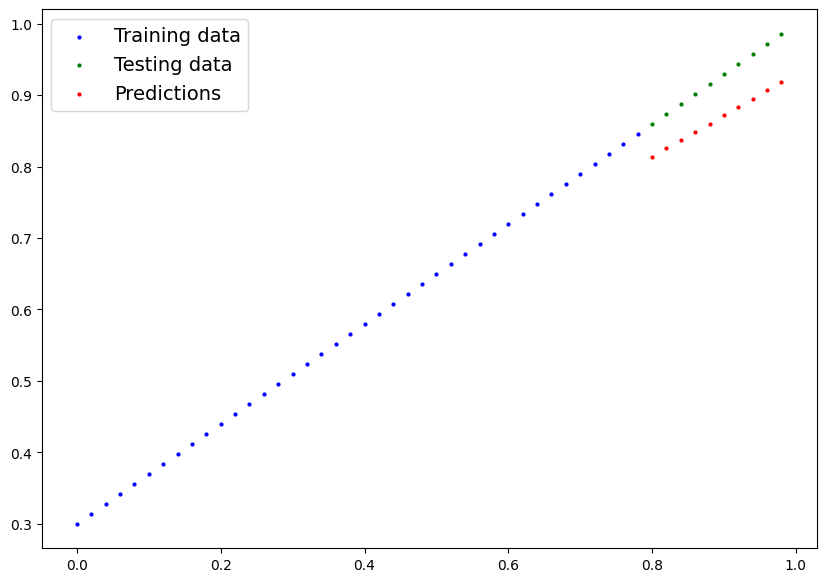

In [72]:
plot_prediction(predictions=y_preds_new)